# Measuring Cell Truncation

Many morphological cell-typing methods rely on dendritic and/or axonal features that require near complete cell reconstructions. While the automated segmentation is very impressive, most cells require extensive proofreading to reach the level of reconstruction needed for cell-typing. This notebook will walk through how we measured the levels of cell truncation due to segmentation errors and volume boundaries to illustrate the need for a truncation insensitive method for dataset wide cell-typing.

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import caveclient
import scipy as sp
import matplotlib.pyplot as plt

/Users/leilae/anaconda3/envs/micronsbinder/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/Users/leilae/anaconda3/envs/micronsbinder/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/Users/leilae/anaconda3/envs/micronsbinder/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/Users/leilae/anaconda3/envs/micronsbinder/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)


# Volume Boundary Truncations

To estimate the percent of cells whose morphologies would be substantially truncated due to being near the volume boundaries, we measured the radial extent for a densely sampled subset of neurons. These cells were selected from an internal column of the dataset and include cells from Layer I - Layer VI. More details about these cells and the subsequent analysis can be found in the following manuscripts (Elabbady 2022 and Schneider-Mizell 2023) 

In [3]:
column_df = pd.read_feather('../data/column_radial_truncation_v795.feather')
column_df.head()

,root_id,radial_extent_dendrite,classification_system,cell_type,id
0,864691135570190726,147.441307,aibs_coarse_excitatory,L2c,256546
1,864691136619397005,111.716174,aibs_coarse_excitatory,L3a,258317
2,864691135737224836,154.055844,aibs_coarse_excitatory,L6wm,312015
3,864691135941715060,138.142983,aibs_coarse_excitatory,L6wm,347173
4,864691135476662696,117.010702,aibs_coarse_excitatory,L6tall-a,307222


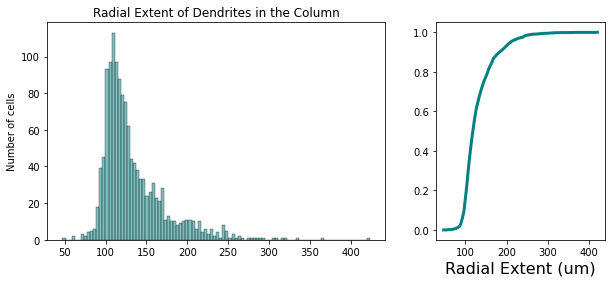

In [20]:

#Plotting a histogram of the radial extent of all the neurons in the column
f, ax = plt.subplots(1,2,figsize=(10,4),gridspec_kw={'width_ratios': [2, 1]})
sns.histplot(column_df.radial_extent_dendrite,bins=100,color='teal',alpha=0.5,ax=ax[0])
ax[0].set_xlabel('')
ax[0].set_ylabel('Number of cells')
ax[0].set_title('Radial Extent of Dendrites in the Column')

#Calculating the cumulative distribution of these cells with respect to radial exent
all_vals = []  
vals, edges = np.histogram(column_df.radial_extent_dendrite, bins=100)
pdf = vals / sum(vals)   
cdf = np.cumsum(pdf)

#Plotting the cumulative distribution
ax[1].set_xlabel('Radial Extent (um)', size=16)    
ax[1].plot(edges[:-1], cdf, color='teal', linewidth=3)

plt.show()

Now let's look at how this compares to the rest of the rest of the cells in the dataset, irrespective of their reconstruction status

In [7]:
#Reading in the nucleus table with all the cells in the dataset
client = caveclient.CAVEclient('minnie65_phase3_v1')
nuc_df = client.materialize.query_table('nucleus_detection_v0',split_positions=True)
mm_df = client.materialize.query_table('aibs_metamodel_celltypes_v661')

#Filtering out any error cells by selecting only those in the latest cell-type table
mm_ids = mm_df.id_ref.tolist()
nuc_df = nuc_df.query('id in @mm_ids')

In [9]:
#Converting our positions into nanometers
nuc_df['pt_position_z_nm'] = nuc_df.pt_position_z * 40
nuc_df['pt_position_x_nm'] = nuc_df.pt_position_x * 4
nuc_df['pt_position_y_nm'] = nuc_df.pt_position_y * 4

Detecting the volume boundaries in the Z axis is pretty straight forward as it defined defined by the first and last section collected and is consistent across the volume. However, the X axis is a little more nuanced since there can be a little jitter after all the sections have been realigned. To account for this, we binned the entire volume and took the average minimum and maximum in X as the volume edge for each bin.

In [21]:
res = 5000
min_z = nuc_df.pt_position_z_nm.min()
max_z = nuc_df.pt_position_z_nm.max() 

#Calculating the left edge of the volume for each bin
min_vol=sp.stats.binned_statistic(nuc_df.pt_position_z_nm, nuc_df.pt_position_x_nm,
 bins=np.arange(min_z, max_z,res), statistic='min')

#Calculating the right edge of the volume for each bin
max_vol=sp.stats.binned_statistic(nuc_df.pt_position_z_nm, nuc_df.pt_position_x_nm,
 bins=np.arange(min_z, max_z,res), statistic='max')

In [12]:
nuc_df['binnumber'] = min_vol.binnumber

Now that that's done, we can measure the minimum distance for each cell from the edges of the volume in X and Z.

In [13]:
#calculate the min z distance for each cell
back_dist = nuc_df.pt_position_z_nm - min_z
front_dist = max_z = nuc_df.pt_position_z_nm 

min_dist = []
for t in zip(back_dist,front_dist):
    back = t[0]
    front = t[1]
    if back <= front:
        min_dist.append(back)
    else:
        min_dist.append(front)
        
nuc_df['min_dist_z_nm'] = min_dist
nuc_df['min_dist_z'] = nuc_df['min_dist_z_nm']/1000

In [14]:
#calculate the min x distance for each cell
min_dist = []
for ix,i in nuc_df.iterrows():
    binnum = i.binnumber
    if binnum == 101:
        binnum=100
    minx = min_vol.statistic[binnum-1]
    maxx = max_vol.statistic[binnum-1]
    
    minx_dist = i.pt_position_x_nm - minx
    #if minx_dist < 0:
        #print('minx_dist!')
    maxx_dist = maxx = i.pt_position_x_nm 
    if minx_dist <= maxx_dist:
        min_dist.append(minx_dist)
    else:
        min_dist.append(maxx_dist)
        
nuc_df['min_dist_x_nm'] = min_dist
nuc_df['min_dist_x'] = nuc_df['min_dist_x_nm']/1000

To approximate how close each cell is, we will take the minimum distance to any of the four borders. So if one cell is very close to the left edge of the volume but centered with respect to Z, we will take the distance from that cell's soma to the left edge.

In [16]:
min_dist = []
for t in zip(nuc_df.min_dist_z,nuc_df.min_dist_x):
    z = t[0]
    x = t[1]
    if z <= x:
        min_dist.append(z)
    else:
        min_dist.append(x)
        
nuc_df['min_dist_border'] = min_dist

In [18]:
median_radius = column_df.radial_extent_dendrite.median() #to plot on top of the entire dataset

Now that we have the minimum distances from the border for each cell, let's compare how the distributions compare to the proofread column from above

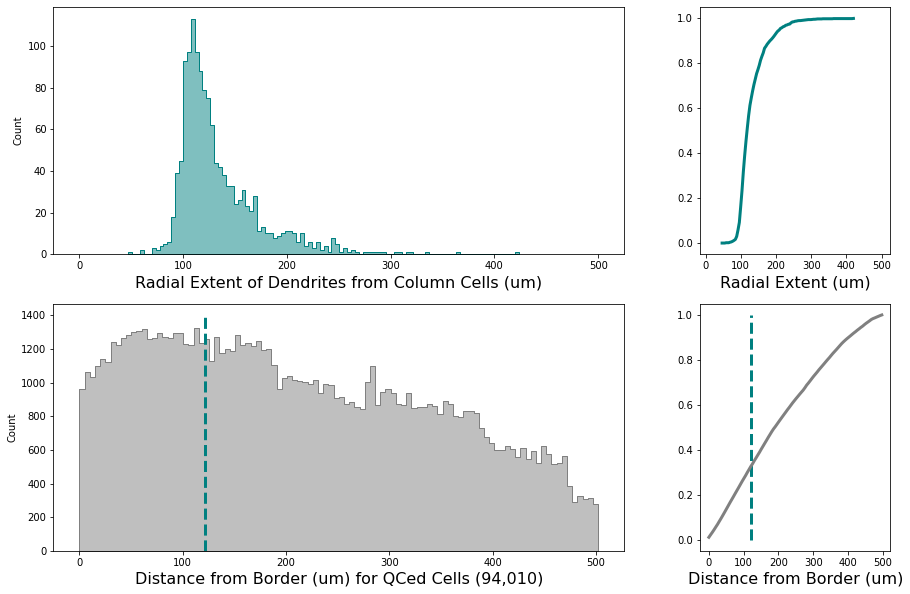

In [19]:
f, ax = plt.subplots(2,2,figsize=(15,10),gridspec_kw={'width_ratios': [3, 1]})

#Replotting the column histogram from above
sns.histplot(column_df.radial_extent_dendrite,bins=100,color='teal',
             element="step", fill=True,
             alpha=0.5,ax=ax[0,0])
ax[0,0].set_xlabel('Radial Extent of Dendrites from Column Cells (um)', size=16)    
ax[0,0].set_xlim((-25,525)) 

#Plotting a histogram of distances from the border across the dataset
sns.histplot(nuc_df.min_dist_border,bins=100,color='gray',
             element="step", fill=True,
             alpha=0.5,ax=ax[1,0])
ax[1,0].set_xlabel('Distance from Border (um) for QCed Cells (94,010)', size=16)    
ax[1,0].vlines(x=median_radius, ymin=0, ymax=1400, colors='teal', ls='--', lw=3)

#Replotting the column cumulative data from above
all_vals = []  
vals, edges = np.histogram(column_df.radial_extent_dendrite, bins=100)
pdf = vals / sum(vals)   
cdf = np.cumsum(pdf)
ax[0,1].set_xlabel('Radial Extent (um)', size=16)    
ax[0,1].plot(edges[:-1], cdf, color='teal', linewidth=3)
ax[0,1].set_xlim((-15,525)) 

#Plotting the cumulative distances across the dataset
all_vals = []  
vals, edges = np.histogram(nuc_df.min_dist_border, bins=100)
pdf = vals / sum(vals)   
cdf = np.cumsum(pdf)
ax[1,1].set_xlabel('Distance from Border (um)', size=16)    
ax[1,1].plot(edges[:-1], cdf, color='gray', linewidth=3)
ax[1,1].vlines(x=median_radius, ymin=0, ymax=1, colors='teal', ls='--', lw=3)

plt.show()

# Segmentation Errors

Full cell reconstructions may require a significant amount of human editing. As such, a given cell's morphology can change drastically before and after proofreading. Below we show a few examples of what that looks like and quantify the overall changes in size and connectivity using a set of over 1,000 cells that have been densley proofread. 

To start, we will compare old and current versions of the same cell using the unique nucleus ID at different versions of the data. Version 661 was used in the accompanying manuscript and version 117 was one of the initial versions where most cells were unproofread

In [121]:
import skeleton_plot as skelplot 
import pcg_skel
import datetime
from meshparty import meshwork
import matplotlib.transforms as mtrans
import matplotlib
from standard_transform.datasets import minnie_transform_vx

In [25]:
client = caveclient.CAVEclient('minnie65_public')

version = 661
timestamp_661 = client.materialize.get_version_metadata(version=version)['time_stamp']

#collecting the unique cell ids for version 661
nuc_df = client.materialize.query_table('nucleus_detection_v0', timestamp=timestamp_661)

#querying the same table at one of the oldest versions to get the old segid
old_nuc_df = client.materialize.query_table('nucleus_detection_v0', materialization_version=117)

#applying a voxel transform to correct the cell positions across layers
tform_nm = minnie_transform_vx()
cell_pos_um = tform_nm.apply(np.vstack(nuc_df.pt_position.values))
nuc_df['cell_pos_um']=[x for x in cell_pos_um]

# split cell_pos_um into 3 columsn for x,y,z
nuc_df[['x','y','z']] = pd.DataFrame(nuc_df.cell_pos_um.tolist(), index= nuc_df.index)

In [26]:
col_edits_df =pd.read_pickle('../data/column_edits_df.pkl')

In [27]:
# merge nuc_df with col_edits_df on pt_root_id and root_id 
nuc_dfm = nuc_df.merge(col_edits_df, left_on='pt_root_id', right_on='root_id', how='right')

In [149]:
old_timestamp = datetime.datetime(2020, 11,5,0,0, tzinfo=datetime.timezone.utc) #initial timestamp for the dataset
new_id= 864691135539304050 #excitatory cell example - for an inhibitory example use 864691136009588396, 864691135539304050
old_id = client.chunkedgraph.suggest_latest_roots(new_id, timestamp=old_timestamp, stop_layer=4)
print(new_id, old_id)

864691135539304050 864691135725589055


In [150]:
#skeleton object of the initial cell
old_mw =  pcg_skel.coord_space_meshwork(
    root_id=old_id,
    client=client,
    root_point=nuc_dfm[nuc_dfm.pt_root_id==new_id].pt_position.values[0],
    root_point_resolution=[4, 4, 40],
    collapse_soma=True)


#skeleton object of the proofread cell
new_mw =  pcg_skel.coord_space_meshwork(
    root_id=new_id,
    client=client,
    root_point=nuc_dfm[nuc_dfm.pt_root_id==new_id].pt_position.values[0],
    root_point_resolution=[4, 4, 40],
    collapse_soma=True,
    synapses="all",
    synapse_table="synapses_pni_2",
    timestamp=timestamp_661)

100%|██████████| 8038/8038 [00:00<00:00, 17088.46it/s]


In [151]:
#for visualization purposes lets get all the skeleton nodes associated with the axon and their volumetric properties 
#this information is publicly available for all skeletons released with the MICrONS dataset
axon_inds, Q = meshwork.algorithms.split_axon_by_annotation(new_mw, pre_anno='pre_syn', post_anno='post_syn')


#let's add these annotations as an axon mask
new_mw.anno.add_annotations('is_axon', axon_inds, mask=True)

#adding volumetric and radial properties along the skeleton
pcg_skel.features.add_volumetric_properties(new_mw, client)
pcg_skel.features.add_segment_properties(new_mw)

r_sk = new_mw.mesh_property_to_skeleton(
    new_mw.anno.segment_properties.df['r_eff'],
)
new_mw.skeleton.vertex_properties['radius'] = r_sk/100


#and the same of the initial version 
#note that the initial version does not have axon annotations but we can use synapse information to infer that below
pcg_skel.features.add_volumetric_properties(old_mw, client)
pcg_skel.features.add_segment_properties(old_mw)

r_sk_old = old_mw.mesh_property_to_skeleton(
    old_mw.anno.segment_properties.df['r_eff'],
)
old_mw.skeleton.vertex_properties['radius'] = r_sk_old/100

In [152]:
#specifying axon color
old_axon_color = np.ones(old_mw.skeleton.vertices.shape[0], dtype=int)

axon_color = np.ones(new_mw.skeleton.vertices.shape[0], dtype=int)
axon_color[new_mw.anno['is_axon'].skel_index]=2

Let's look at how this cell changes before and after proofreading

Text(0.5, 1.0, 'Unproofread Cell')

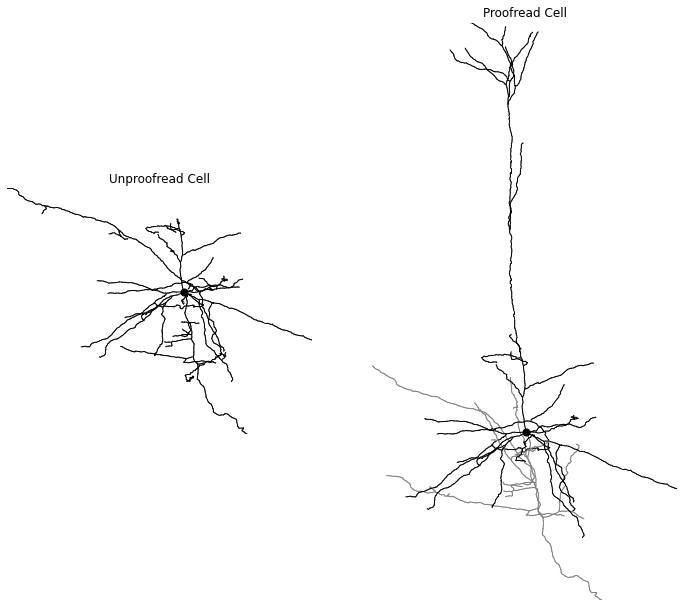

In [153]:
f, ax = plt.subplots(1,2,figsize=(12,12))
skelplot.plot_tools.plot_skel(
    new_mw.skeleton,
    ax=ax[1],
    pull_radius=False,
    plot_soma = True,
    soma_size=50,
    skel_colors=axon_color,
    invert_y=True,
    skel_color_map = {2: 'gray', 1: 'black'}
)
# turn off the axis
ax[1].axis('off')
ax[1].set_title('Proofread Cell')

skelplot.plot_tools.plot_skel(
    old_mw.skeleton,
    ax=ax[0],
    plot_soma=True,
    soma_size=50,
    #pull_radius=True, 
    skel_colors=old_axon_color,
    invert_y=True,
    skel_color_map = {2: 'gray', 1: 'black'}
)
# turn off the axis
ax[0].axis('off')
ax[0].set_title('Unproofread Cell')

As  you can see the proofread cell has quite a bit of added axon and dendrite as compared to the initial segmentation. How does this change the connectivity information with respect to synapses? Below we will plot the number of pre and postsynapses added and removed with proofreading.

In [154]:
#querying for synapses from the initial cell segmentation
old_in_df=client.materialize.live_live_query(client.materialize.synapse_table, 
                                             old_timestamp,
                                             filter_equal_dict={client.materialize.synapse_table:{'post_pt_root_id': old_id}})

#querying for synapses from the proofread cell segmentation
new_in_df=client.materialize.live_live_query(client.materialize.synapse_table, 
                                             timestamp_661,
                                             filter_equal_dict={client.materialize.synapse_table:{'post_pt_root_id': new_id}},
                                             desired_resolution=[1,1,1],
                                             split_positions=True)

In [155]:
new_roots = client.chunkedgraph.get_latest_roots(old_id, timestamp=timestamp_661)
all_old_in_syn_df = client.materialize.synapse_query(post_ids=new_roots, timestamp=timestamp_661, 
                                                     desired_resolution=[1,1,1], split_positions=True)


all_old_in_syn_df['post_pt_root_id']= client.chunkedgraph.get_roots(all_old_in_syn_df.post_pt_supervoxel_id.values,
                                                                    timestamp=old_timestamp)

# filter this list where post_pt_root_id ==old_id 
all_old_in_syn_df=all_old_in_syn_df[all_old_in_syn_df.post_pt_root_id==old_id]

#mark the is_correct column of all_old_in_syn_df with True if the synapse id can be found in new_in_df
all_old_in_syn_df['is_correct']=all_old_in_syn_df.id.isin(new_in_df.id.values)

# mark the is_correct column of new_in_df with True if the synapse id can be found in old_in_df
new_in_df['is_correct'] = new_in_df.id.isin(all_old_in_syn_df.id.values)


Now let's visualize the skeletons again, this time with added synapse information. The initially correct synapses that were maintained with proofreading are show in orange. Synapses that were removed with proofreading are shown on the left in light blue triangles, those added with proofreading are shown on the right in dark blue synapses

(3471, 19)


Text(0.5, 1.0, 'Unproofread Cell')

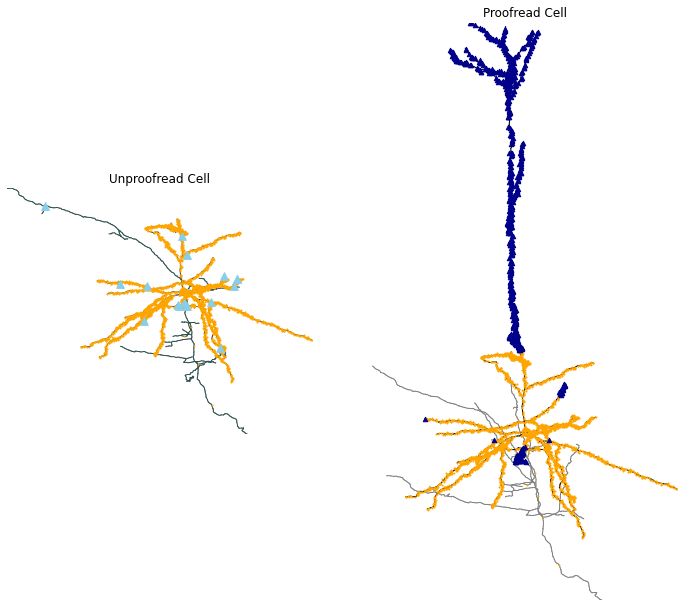

In [156]:
f, ax = plt.subplots(1,2,figsize=(12,12))
skelplot.plot_tools.plot_skel(
    new_mw.skeleton,
    ax=ax[1],
    #pull_radius=True, 
    plot_soma=True,
    soma_size=50,
    skel_colors=axon_color,
    invert_y=True,
    skel_color_map = {2: 'gray', 1: 'black'}
)
correct_syn = new_in_df[new_in_df.is_correct]
incorrect_syn = new_in_df[~new_in_df.is_correct]
incorrect_syn=incorrect_syn[incorrect_syn.pre_pt_root_id!=incorrect_syn.post_pt_root_id]

#scatterplot of the maintained correct synapses in orange
ax[1].scatter(correct_syn.post_pt_position_x.values, correct_syn.post_pt_position_y.values, s=1, c='orange', zorder=9)
#scatterplot of the newly added synapses in dark blue triangles
ax[1].scatter(incorrect_syn.post_pt_position_x.values, incorrect_syn.post_pt_position_y.values, s=20, c='darkblue', marker='^', zorder=9)
# turn off the axis
ax[1].axis('off')
ax[1].set_title('Proofread Cell')

skelplot.plot_tools.plot_skel(
    old_mw.skeleton,
    ax=ax[0],
    #pull_radius=True, 
    plot_soma=True,
    soma_size=50,
    invert_y=True,
    skel_color_map = {2: 'gray', 1: 'black'}
)
# turn off the ax
correct_syn = all_old_in_syn_df[all_old_in_syn_df.is_correct]
incorrect_syn = all_old_in_syn_df[~all_old_in_syn_df.is_correct]
incorrect_syn=incorrect_syn[incorrect_syn.pre_pt_root_id!=incorrect_syn.post_pt_root_id]
print(correct_syn.shape)
# add a scatter plot of initially correct synapses in orange
ax[0].scatter(correct_syn.post_pt_position_x.values, correct_syn.post_pt_position_y.values, s=1, c='orange', zorder=9)
# add a scatter plot of the removed incorrect synapses in blue triangles
ax[0].scatter(incorrect_syn.post_pt_position_x.values, incorrect_syn.post_pt_position_y.values, s=60, c='skyblue', marker='^', zorder=9)
# turn of the axis
ax[0].axis('off')
ax[0].set_title('Unproofread Cell')

That is for one cell, how does this look for all the proofread cells in the column? For this we will read in a dataframe that has precomputed the information we just calculated for one cell above but for all the proofread cells in the column. 

In [135]:
syn_edits = pd.read_pickle('../data/column_syn_edits_df.pkl')
syn_edits.head()


,root_id,old_root_id_in,removed_syn_in,added_syn_in,correct_syn_in,proofread_syn_count_in,initial_syn_count_in,prop_removed_syn_in,prop_added_syn_in,prop_missing_syn_in,...,prop_added_syn_out,prop_missing_syn_out,prop_correct_syn_out,vol_both,vol_orig,vol_curr,total_proofread_volume,fraction_changed,fraction_added,fraction_removed
0,864691136009588396,864691136422863151,59,4,5447,5451,5506,0.010716,0.000734,0.000726,...,0.838150,0.114444,0.022099,2314.050365,955.313004,482.837322,1842.083814,0.780719,0.262115,0.518605
1,864691135565275479,864691135341131973,29,7,6399,6406,6428,0.004512,0.001093,0.001089,...,0.968067,10.472727,0.345455,2552.272223,3874.358723,1394.851620,1842.083814,2.860462,0.757214,2.103248
2,864691136452054015,864691135526088027,179,1009,12532,13541,12711,0.014082,0.074514,0.079380,...,0.396412,0.453242,0.690119,5034.346388,3347.030490,1931.494129,1842.083814,2.865518,1.048538,1.816981
3,864691135938356484,864691136333946547,24,521,5205,5726,5229,0.004590,0.090988,0.099637,...,0.563953,0.140173,0.108382,3754.978381,3507.849605,949.920276,1842.083814,2.419960,0.515677,1.904283
4,864691135272867601,864691135841056483,45,4,3584,3588,3629,0.012400,0.001115,0.001102,...,0.839623,0.659259,0.125926,1721.899284,424.324311,528.263747,1842.083814,0.517125,0.286775,0.230350


In [136]:
#changing the format of the dataframe to help with visualization below
melted_df = syn_edits.melt(id_vars='root_id', 
                value_vars=['prop_removed_syn_in', 'prop_added_syn_in', 'prop_correct_syn_in',
        'prop_removed_syn_out', 'prop_added_syn_out','prop_correct_syn_out','fraction_changed', 
                            'fraction_added', 'fraction_removed'])
melted_df

,root_id,variable,value
0,864691136009588396,prop_removed_syn_in,0.010716
1,864691135565275479,prop_removed_syn_in,0.004512
2,864691136452054015,prop_removed_syn_in,0.014082
3,864691135938356484,prop_removed_syn_in,0.004590
4,864691135272867601,prop_removed_syn_in,0.012400
...,...,...,...
9121,864691136663316702,fraction_removed,0.657042
9122,864691135976202563,fraction_removed,0.069288
9123,864691136287166915,fraction_removed,0.021244
9124,864691136041818198,fraction_removed,0.057417


In [137]:
#custom color dict
color_dict = {
    'prop_removed_syn_in':'#000000', 
    'prop_added_syn_in':'#000000',
    'prop_correct_syn_in':'#000000',
    'prop_removed_syn_out':'#808080', 
    'prop_added_syn_out':'#808080',
    'prop_correct_syn_out':'#808080',
    'fraction_added': '#008080'  ,
    'fraction_removed': '#89D5D2'
    
}

#adding a labeled column for ease of visualization filtering
comp=[]
for v in melted_df.variable:
    if 'removed_syn' in v:
        comp.append('removed_syn')
    elif 'added_syn' in v:
        comp.append('added_syn')
    elif 'correct_syn' in v:
        comp.append('correct_syn')
    elif 'fraction' in v:
        comp.append('volume')
    else:
        comp.append('other')
melted_df['comparison'] = comp

Now let's visualize the proportion of removed, added and correct synapses both presynaptic and postsynaptic for all the proofread cells. Across all three panels, presynaptic synapse information is shown in gray, postsynaptic in black.

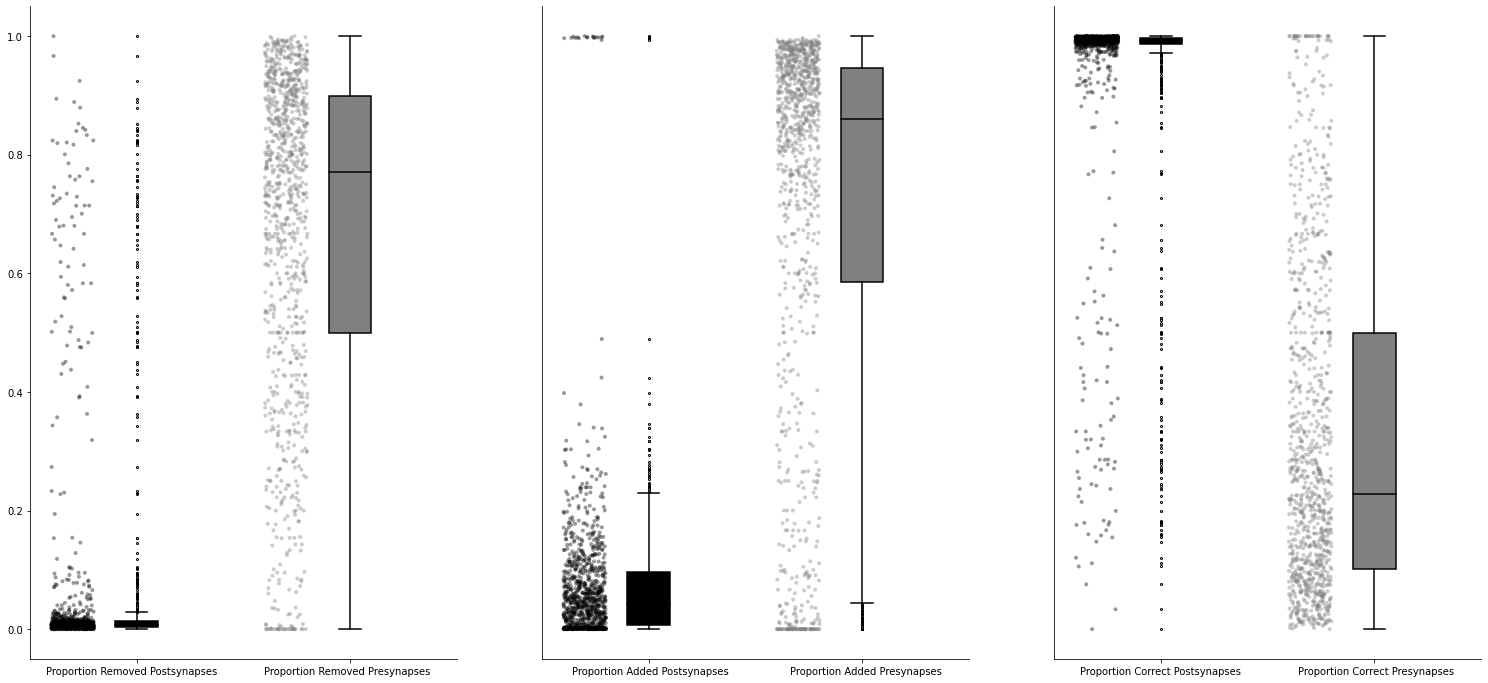

In [138]:
def change_width(ax, new_value):
    for patch in ax.patches:
        current_width = patch.get_width()
        diff = current_width - new_value

        # change patch width
        patch.set_width(new_value)

        # re-center patch
        patch.set_x(patch.get_x() + diff * .5)
        
boxplot_width = .2 # thinner to make room for having swarmplot beside
stripplot_offset = -.3 # offset to left of boxplot
xlim_offset = -1 # necessary to show leftmost swarmplot  

f, ax = plt.subplots(1,3,figsize=(26,12))
comps = ['removed_syn', 'added_syn', 'correct_syn']
x_labels = [['Proportion Removed Postsynapses','Proportion Removed Presynapses'],
            ['Proportion Added Postsynapses','Proportion Added Presynapses'],
            ['Proportion Correct Postsynapses','Proportion Correct Presynapses']]
for i in range(3):
    comp = comps[i]
    sns.stripplot(x='variable',y='value', 
                  data = melted_df.query('comparison==@comp'),
                  palette = color_dict,s=4, ax=ax[i], alpha=0.4)

    path_collections = [child for child in ax[i].get_children() 
                        if isinstance(child,matplotlib.collections.PathCollection)] 

    for path_collection in path_collections: 
        x,y = np.array(path_collection.get_offsets()).T 
        xnew = x + stripplot_offset
        offsets = list(zip(xnew,y)) 
        path_collection.set_offsets(offsets)


    flierprops = dict(marker='o', markerfacecolor='None', markersize=2,  markeredgecolor='black')

    sns.boxplot(x='variable',y='value', 
                  data = melted_df.query('comparison==@comp'),
                  palette = color_dict,ax=ax[i],width=boxplot_width,
                  flierprops=flierprops)

    ax[i].set_xticklabels(x_labels[i])
    
   
    trans = mtrans.Affine2D().translate(80, 0)
    for t in ax[i].get_xticklabels():
        t.set_transform(t.get_transform()+trans)

    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    for ix,box in enumerate(ax[i].artists):
        box.set_edgecolor('black')
        #box.set_facecolor('white')

        # iterate over whiskers and median lines
        for j in range(6*i,6*(ix+1)):
             ax[i].lines[j].set_color('black')

    change_width(ax[i],.25)
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), ha="right") # align labels to left
    if i>0:
        ax[i].set_yticks([])
        ax[i].set_ylabel('')

plt.show()

Finally, where do these edits occur along the cell? For this we will look at the cumulative distribution of all the edits as a function of distance from the soma. The main takeaway here is the for almost all cells - there are 0-1 edits made within 20 microns of the nucleus center.

In [157]:
import pickle

In [158]:
#reading in a data file that has, for each cell, precomputed the distance from the soma for each edit 

file = open("../data/column_edit_distances.pkl",'rb')
all_edit_ds = pickle.load(file)

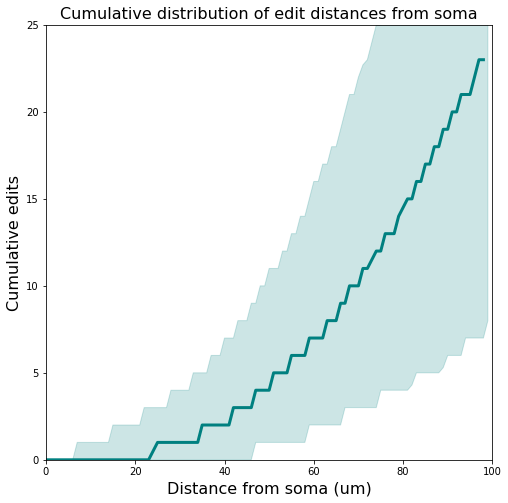

In [159]:
# make a plot of the cumulative distribution of the edit distances
# for each of the root_ids in the all_edits_ds list

fig, ax = plt.subplots(figsize=(8,8))
all_vals = []
for edit_ds in all_edit_ds.values():
    vals, edges = np.histogram(edit_ds/1000, bins=np.arange(0,100,1))
    vals = np.cumsum(vals)
    all_vals.append(vals)

ax.set_xlabel('Distance from soma (um)', size=16)    
ax.set_ylabel('Cumulative edits', size=16)
ax.set_title('Cumulative distribution of edit distances from soma', size=16)
ax.set_xlim(0,100)
ax.set_ylim(0,25)
med_vals=np.median(np.vstack(all_vals), axis=0)
perc_vals=np.percentile(np.vstack(all_vals), [10,25,75,90], axis=0)


ax.plot(edges[:-1], med_vals, color='teal', linewidth=3)
    
plt.fill_between(np.arange(1,100,1),perc_vals[0,:], perc_vals[3,:], alpha=0.2, color='teal')
plt.show()